In [1]:
import json 

In [2]:
# Preprocess the first dataset ( Entity Recognition) before merging with old dataset

def preprocess_resumes(json_file_path):
    dataset = []
    with open(json_file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                item = json.loads(line)
                text = item.get("content", "")
                entities = []
                for ann in item.get("annotation", []):
                    labels = ann.get("label", [])
                    label_value = labels[0] if labels else ""
                    for point in ann.get("points", []):
                        start = point.get("start")
                        end   = point.get("end")
                        if start is not None and end is not None:
                            entities.append([start, end, label_value])
                dataset.append([text, {"entities": entities}])
            except json.JSONDecodeError as e:
                print(f"JSON decoding error in line: {line[:50]}... Error: {e}")
            except Exception as e:
                print(f"Unexpected error processing line: {line[:50]}... Error: {e}")
    
    return dataset



In [3]:
json_file_path = '/kaggle/input/datacollection-resumes/Entity Recognition in Resumes.json'
dataset1 = preprocess_resumes(json_file_path)

print(dataset1[0])

["Abhishek Jha\nApplication Development Associate - Accenture\n\nBengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a\n\n• To work for an organization which provides me the opportunity to improve my skills\nand knowledge for my individual and company's growth in best possible ways.\n\nWilling to relocate to: Bangalore, Karnataka\n\nWORK EXPERIENCE\n\nApplication Development Associate\n\nAccenture -\n\nNovember 2017 to Present\n\nRole: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries\nfor the Bot which will be triggered based on given input. Also, Training the bot for different possible\nutterances (Both positive and negative), which will be given as\ninput by the user.\n\nEDUCATION\n\nB.E in Information science and engineering\n\nB.v.b college of engineering and technology -  Hubli, Karnataka\n\nAugust 2013 to June 2017\n\n12th in Mathematics\n\nWoodbine modern school\n\nApril 2011 to March 2013\n\n10th\n\nKendriya Vidyalaya\n

In [4]:
#Open the second dataset 
json_file_path = '/kaggle/input/datacollection-resumes/train_data.json'
with open(json_file_path, "r", encoding="utf-8") as f:
    dataset2 = json.load(f)

In [5]:
# Get inforamtion about the dataset 
def compute_metrics(documents):
    text_lengths = []        
    annotations_count = []  
    annotation_labels = []

    for doc in documents:
        if not isinstance(doc, list) or len(doc) != 2:
            print(f"Skipping document with unexpected structure: {doc}")
            continue

        text, ann_dict = doc[0], doc[1]
        text_lengths.append(len(text))
        entities = ann_dict.get("entities", [])
        annotations_count.append(len(entities))
        
        for entity in entities:
            if len(entity) >= 3:
                annotation_labels.append(entity[2])
            else:
                print(f"Unexpected entity format: {entity}")

    num_docs = len(text_lengths)
    total_annotations = sum(annotations_count)
    avg_text_length = sum(text_lengths) / num_docs if num_docs > 0 else 0
    avg_annotations_per_doc = total_annotations / num_docs if num_docs > 0 else 0

    metrics = {
        "total_documents": num_docs,
        "total_annotations": total_annotations,
        "avg_text_length": avg_text_length,
        "avg_annotations_per_doc": avg_annotations_per_doc,
        "annotation_labels": annotation_labels
    }
    
    return metrics

In [6]:
def print_metrics(metrics):
    print("========== Basic Dataset Statistics ==========")
    print(f"Total documents: {metrics.get('total_documents', 0)}")
    print(f"Total annotations: {metrics.get('total_annotations', 0)}")
    print(f"Average text length: {metrics.get('avg_text_length', 0):.2f} characters")
    print(f"Average annotations per document: {metrics.get('avg_annotations_per_doc', 0):.2f}")
   

In [7]:
dataset1_infor = compute_metrics(dataset1)
print_metrics(dataset1_infor)

========== Basic Dataset Statistics ==========
Total documents: 220
Total annotations: 3558
Average text length: 3697.14 characters
Average annotations per document: 16.17


In [8]:
dataset2_infor = compute_metrics(dataset2)
print_metrics(dataset2_infor)

========== Basic Dataset Statistics ==========
Total documents: 200
Total annotations: 3206
Average text length: 3704.95 characters
Average annotations per document: 16.03


In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
label_counter_1 = Counter(dataset1_infor['annotation_labels'])
print("\n---------- Distinct Annotation Labels ----------")
for label, count in label_counter_1.items():
    print(f"{label}: {count}")


---------- Distinct Annotation Labels ----------
Skills: 472
College Name: 330
Graduation Year: 254
Designation: 521
Companies worked at: 729
Email Address: 252
Location: 430
Name: 224
Degree: 298
Years of Experience: 44
UNKNOWN: 2
: 2


In [11]:
label_counter_2 = Counter(dataset2_infor['annotation_labels'])
print("\n---------- Distinct Annotation Labels ----------")
for label, count in label_counter_2.items():
    print(f"{label}: {count}")


---------- Distinct Annotation Labels ----------
Companies worked at: 676
Skills: 417
Graduation Year: 222
College Name: 291
Degree: 268
Designation: 473
Email Address: 229
Location: 381
Name: 205
Years of Experience: 42
UNKNOWN: 2


In [12]:
def find_duplicate_resumes_by_text(dataset1, dataset2):
    duplicates = []
    texts1 = set()
    for doc in dataset1:
        if isinstance(doc, list) and len(doc) == 2:
            text = doc[0].strip()
            if text:
                texts1.add(text)
    for doc in dataset2:
        if isinstance(doc, list) and len(doc) == 2:
            text = doc[0].strip()
            if text in texts1:
                duplicates.append(text)
    
    return duplicates
duplicate_texts = find_duplicate_resumes_by_text(dataset1, dataset2)
if duplicate_texts:
    print("Duplicate resumes (by text) found:")
    for idx, dup in enumerate(duplicate_texts, 1):
        print(f"{idx}. {dup[:100]}...")
else:
    print("No duplicate resumes found by text match.")


No duplicate resumes found by text match.


In [13]:
merged_dataset = dataset1 + dataset2
output_file = "merged_dataset.json"    
    # Write the merged dataset to a JSON file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(merged_dataset, f, ensure_ascii=False, indent=4)
    
print(f"Merged dataset has been saved to '{output_file}'")

Merged dataset has been saved to 'merged_dataset.json'


In [14]:
merged_counter = label_counter_1 + label_counter_2

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


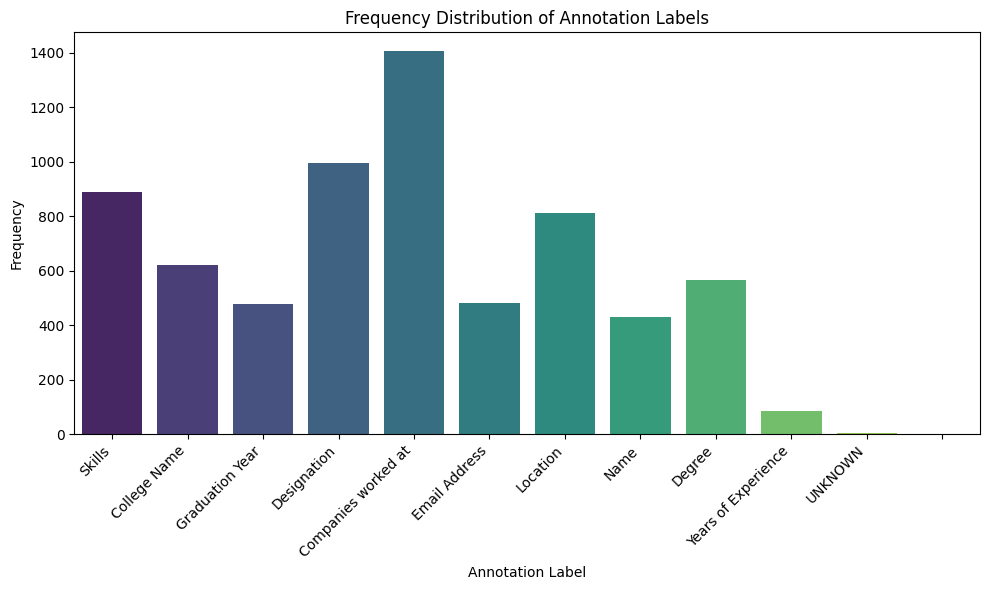

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(x=list(merged_counter.keys()), y=list(merged_counter.values()), palette="viridis")
plt.xlabel("Annotation Label")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Annotation Labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
def remove_unknown_annotations(input_file, output_file):

    with open(input_file, "r", encoding="utf-8") as f:
        dataset = json.load(f)

    for doc in dataset:
        if isinstance(doc, list) and len(doc) == 2:
            ann_dict = doc[1]
            entities = ann_dict.get("entities", [])
            filtered_entities = [entity for entity in entities if len(entity) >= 3 and entity[2] != "UNKNOWN"]
            ann_dict["entities"] = filtered_entities
    
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(dataset, f, ensure_ascii=False, indent=4)
    
    print(f"Saved filtered dataset to {output_file}")

input_json_file = "merged_dataset.json"  
output_json_file = "merged_dataset_cleaned.json"

remove_unknown_annotations(input_json_file, output_json_file)


Saved filtered dataset to merged_dataset_cleaned.json


In [17]:
plt.figure(figsize=(10,6))
sns.histplot(text_lengths, bins=30, kde=True, color="steelblue")
plt.xlabel("Text Length (Number of Characters)")
plt.ylabel("Number of Documents")
plt.title("Distribution of Text Length in Documents")
plt.tight_layout()
plt.show()

NameError: name 'text_lengths' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(annotations_count, bins=range(0, max(annotations_count)+2), color='salmon', edgecolor='black')
plt.xlabel("Number of Annotations per Document")
plt.ylabel("Number of Documents")
plt.title("Distribution of Annotations per Document")
plt.tight_layout()
plt.show()